# 超参数和正则化

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. K-fold cross-validation K折交叉验证

又称 K-CV。在 K-CV 中，我们把训练集均分成 K 个互斥的子集，然后做 K 次训练和验证，每次都用其中一个子集做验证集，剩下的 K-1 个子集合并成一个新的训练集。这 K 次里面每次选用的验证集都不同。然后我们把这 K 次的训练误差和验证误差的均值作为整体的训练误差和验证误差。

In [ ]:
## 请先自行定义一个训练函数 train 和简单的网络 net
## 函数 train 返回两个参数 （训练误差，验证误差）
def k_cv(k, epochs, X_train, y_train, lr):
    #fold_size = 1
    ## 定义每个子集的长度 fold_size，将训练集均等分为 k 份
    fold_size = X_train.shape[0] // k
    
    ## 预留数组储存每一次的训练误差和验证误差
    train_error = [0.0] * k
    eval_error = [0.0] * k
    for i in range(k):
        ## 划分每一轮循环的训练集和验证集
        ## 定义验证集下标的起点和终点
        val_idx_start = i * fold_size
        val_idx_stop = (i + 1) * fold_size
        val_idx = range(val_idx_start, val_idx_stop)
        train_idx = range(0, val_idx_start) + range(val_idx_stop, X_train.shape[0])
        X_val = X_train[val_idx, :]
        y_val = y_train[val_idx]
        X_tr = X_train[train_idx, :]
        y_tr = y_train[train_idx]
        te, ee = train(net, X_tr, y_tr, X_val, y_val, epochs, lr)
        train_error[i] = te
        eval_error[i] = ee
    return np.mean(train_eroro), np.mean(eval_error)

请试着把它用在后面的超参数选择过程中。

## 2. Early stopping 提前终止

In [2]:
import mxnet as mx
from mxnet import nd
from mxnet import autograd
from mxnet.gluon import data as gdata
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import init
from mxnet.gluon import loss as gloss

C:\Users\Hikaru\Anaconda2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


建一个简单的带有噪声的数据集，我们用 x 和 y_real 做后面的训练。
y_real 与 x 的关系满足多项式 $$y = x^2 + noise$$

随机噪声满足标准正态分布

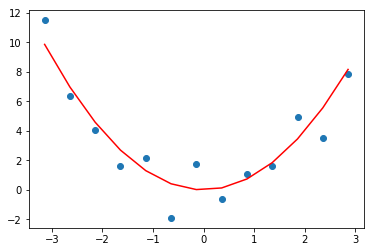

In [3]:
np.random.seed(1)
x = np.arange(-np.pi, np.pi, 0.5)
y_exp = x**2
y_real = y_exp + np.random.randn(len(x))
plt.scatter(x, y_real)
plt.plot(x, y_exp, 'r-')
plt.show()

红线表示数据理想的样子，蓝点表示加了噪声之后数据的样子。

In [4]:
## 划分训练集和验证集
np.random.seed(2)
shuffle_idx = np.random.permutation(len(x))
split_idx = len(x) * 2 / 3
x_train = nd.array(x[shuffle_idx[:split_idx]])
y_train = nd.array(y_real[shuffle_idx[:split_idx]])
x_val = nd.array(x[shuffle_idx[split_idx:]])
y_val = nd.array(y_real[shuffle_idx[split_idx:]])

In [5]:
## 定义损失函数
loss = gloss.L2Loss()

In [6]:
## 定义网络结构，这里还是使用两层的前馈网络，隐藏层的神经元数量可调
def new_net(num_neurons):
    net = nn.Sequential()
    net.add(nn.Dense(num_neurons, activation='tanh'))
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=0.1))
    return net

In [7]:
def train(net, X_train, y_train, X_val, y_val, num_epochs, lr, \
         batch_size, draw = False):
    epoch_list = []
    train_err_list = []
    eval_err_list = []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        X_train, y_train), batch_size, shuffle = True)
    trainer = gluon.Trainer(net.collect_params(),'sgd',{'learning_rate': lr})
    ## 使用交叉验证的话把下面这行的注释去掉
    # net.initialize(init=init.Xavier(), force_reinit=True)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_error = loss(net(X_train), y_train).mean().asscalar()
        if epoch % 100 == 0:
            eval_error = loss(net(X_val), y_val).mean().asscalar()
            epoch_list.append(epoch)
            train_err_list.append(train_error)
            eval_err_list.append(eval_error)
            print "epoch %d, train error: %.4f, validation error: %.4f" % (epoch, train_error, eval_error)
        eval_error = loss(net(X_val), y_val).mean().asscalar()
    if draw:
        draw_something(epoch_list, train_err_list, eval_err_list)
    return train_error, eval_error

In [8]:
def draw_something(epoch_list, train_err_list, eval_err_list):
    plt.plot(epoch_list, train_err_list, label = 'training error')
    plt.plot(epoch_list, eval_err_list, label = 'validation error')
    plt.xlabel('epochs')
    plt.ylabel('error')
    plt.legend()
    plt.show()

In [9]:
## 建一个隐藏层有50个神经元的前馈神经网络
net = new_net(50)

epoch 0, train error: 9.4783, validation error: 11.1730
epoch 100, train error: 5.7461, validation error: 9.0444
epoch 200, train error: 1.3683, validation error: 2.4192
epoch 300, train error: 1.0360, validation error: 2.1728
epoch 400, train error: 0.7096, validation error: 2.5592
epoch 500, train error: 0.5638, validation error: 2.6384
epoch 600, train error: 0.4750, validation error: 2.6898
epoch 700, train error: 0.4040, validation error: 2.7253
epoch 800, train error: 0.3327, validation error: 2.7478
epoch 900, train error: 0.2575, validation error: 2.7649
epoch 1000, train error: 0.1887, validation error: 2.7842
epoch 1100, train error: 0.1349, validation error: 2.8092
epoch 1200, train error: 0.0971, validation error: 2.8392
epoch 1300, train error: 0.0718, validation error: 2.8714
epoch 1400, train error: 0.0550, validation error: 2.9023
epoch 1500, train error: 0.0434, validation error: 2.9294
epoch 1600, train error: 0.0349, validation error: 2.9519
epoch 1700, train error: 

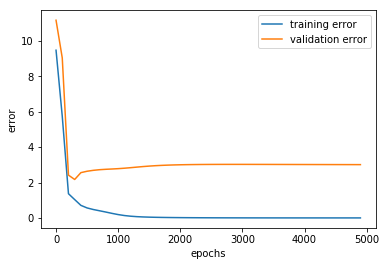

(0.00011162478, 2.995578)

In [10]:
np.random.seed(3)
net.initialize(init.Normal(sigma=0.1), force_reinit=True)
train(net, x_train, y_train, x_val, y_val, 5000, 0.1, 10, draw=True)

虽然不明显，但是还是可以看出 training error 一直在下降， validation error 经历了一个先下降后上升的过程。这就是出现了过拟合。

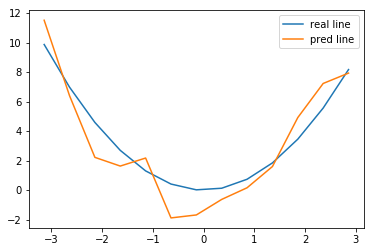

In [11]:
x_test = nd.array(x)
y_pred = net(x_test)
y_plot = y_pred.asnumpy()
plt.plot(x, y_exp, label = 'real line')
plt.plot(x, y_plot, label = 'pred line')
plt.legend()
plt.show()

然后试试在500个epoch时就停下来，其它参数不变。

epoch 0, train error: 9.7593, validation error: 10.8873
epoch 100, train error: 5.5950, validation error: 8.8393
epoch 200, train error: 2.0409, validation error: 3.6833
epoch 300, train error: 1.3766, validation error: 2.6245
epoch 400, train error: 1.0411, validation error: 2.4737


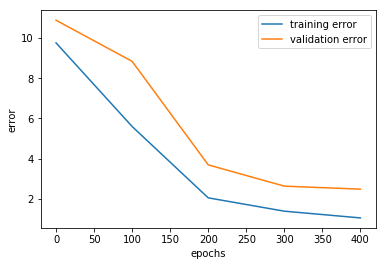

(0.60297894, 2.939097)

In [12]:
np.random.seed(3)
net.initialize(init.Normal(sigma=0.1), force_reinit=True)
train(net, x_train, y_train, x_val, y_val, 500, 0.1, 10, draw=True)

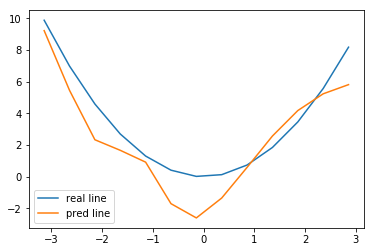

In [13]:
x_test = nd.array(x)
y_pred = net(x_test)
y_plot = y_pred.asnumpy()
plt.plot(x, y_exp, label = 'real line')
plt.plot(x, y_plot, label = 'pred line')
plt.legend()
plt.show()

效果虽然还是过拟合，但是比前面的情况要稍微要好一些。

## 3. Adjust learning rate 调整学习率 lr

学习率会影响收敛的时间，具体的请自行尝试。一般 lr 的取值为 1，0.1，0.01 等，也可以在训练的过程中发生衰减。

请试写一下每 100 个 epoch 之后 lr 衰减为原来的一半的 train 函数。

## 4. L2范数正则化

L2范数正则化，就是在模型原本的损失函数的基础上添加L2范数作为惩罚项。这里我们只对weight做正则化。

所以训练函数就可以改成这样：

In [16]:
def train(net, X_train, y_train, X_val, y_val, num_epochs, lr, \
         batch_size, wd, draw = False):
    epoch_list = []
    train_err_list = []
    eval_err_list = []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        X_train, y_train), batch_size, shuffle = True)
    ## 只对weight做正则化，不考虑bias
    trainer_w = gluon.Trainer(net.collect_params('.*weight'),'sgd',
                              {'learning_rate': lr, 'wd': wd})
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd',
                             {'learning_rate': lr})
    ## 使用交叉验证的话把下面这行的注释去掉
    # net.initialize(init=init.Xavier(), force_reinit=True)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            ## 对两个trainer分别调用step
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        train_error = loss(net(X_train), y_train).mean().asscalar()
        if epoch % 100 == 0:
            eval_error = loss(net(X_val), y_val).mean().asscalar()
            epoch_list.append(epoch)
            train_err_list.append(train_error)
            eval_err_list.append(eval_error)
            print "epoch %d, train error: %.4f, validation error: %.4f" % (epoch, train_error, eval_error)
        eval_error = loss(net(X_val), y_val).mean().asscalar()
    if draw:
        draw_something(epoch_list, train_err_list, eval_err_list)
    return train_error, eval_error

epoch 0, train error: 10.1502, validation error: 10.3478
epoch 100, train error: 6.4119, validation error: 5.9725
epoch 200, train error: 6.2781, validation error: 6.0539
epoch 300, train error: 5.7765, validation error: 5.6948
epoch 400, train error: 4.8256, validation error: 4.6740
epoch 500, train error: 4.4995, validation error: 4.4506
epoch 600, train error: 4.3878, validation error: 4.4218
epoch 700, train error: 4.3573, validation error: 4.4091
epoch 800, train error: 4.3507, validation error: 4.4056
epoch 900, train error: 4.3493, validation error: 4.4048


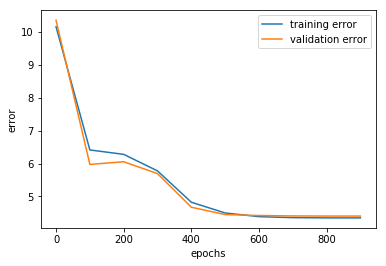

(4.3490257, 4.40468)

In [17]:
np.random.seed(3)
net.initialize(init.Normal(sigma=0.1), force_reinit=True)
train(net, x_train, y_train, x_val, y_val, 1000, 0.1, batch_size=10, wd=1, draw=True)

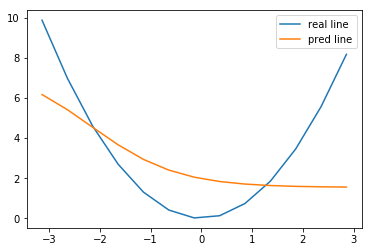

In [18]:
x_test = nd.array(x)
y_pred = net(x_test)
y_plot = y_pred.asnumpy()
plt.plot(x, y_exp, label = 'real line')
plt.plot(x, y_plot, label = 'pred line')
plt.legend()
plt.show()

欠拟合了……但是可以看到线条平滑了不少，这就是正则化的力量。

## 5. 初始化函数的选择

MXNet 的 init 模块提供了几个初始化的方法。具体可以参考 https://mxnet.incubator.apache.org/api/python/optimization/optimization.html#module-mxnet.initializer

需要注意的一点是不能把所有的权重初始化为0，否则？

可以多尝试各种初始化方法，说不定会有惊喜。

也可以自定义初始化函数。

一般使用正态分布初始化的方法保证权重的均值为0。

In [19]:
## 将权重初始化为均值为0，标准差为0.01的正态分布随机数
## 假如不是第一次对参数做初始化，要把force_reinit设成 True
net.initialize(init=init.Normal(sigma = 0.01), force_reinit=True)

可以用这种方式查看每一层的 weight 和 bias

In [20]:
## 输出层的权重第一行
net[1].weight.data()[0]


[-0.0088165  -0.005147   -0.02341325  0.002762    0.01063557 -0.01019689
  0.00374245  0.00941602  0.00053763  0.00805516  0.00112969  0.00529344
  0.00826293 -0.00941042 -0.00616595  0.00597792 -0.00277788 -0.01167859
  0.00923334 -0.00317221  0.00842336 -0.00189047  0.01233136 -0.00972316
 -0.00644789  0.0026323  -0.00340782 -0.00532805 -0.00711909 -0.00716095
  0.01613258  0.00964917  0.02526586 -0.01172786 -0.01702983 -0.00421657
 -0.01005197 -0.01006717  0.00616641  0.00891012 -0.00572187 -0.0140261
 -0.00276108  0.00592655 -0.00195088 -0.01077261 -0.01883068  0.00400938
 -0.00905535 -0.00708639]
<NDArray 50 @cpu(0)>

In [21]:
## 隐藏层的 bias，只有weight满足正态分布，bias初始化为0向量
net[0].bias.data()


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
<NDArray 50 @cpu(0)>

In [22]:
## 也可以单独给某一层的权重初始化
net[0].weight.initialize(init=init.Normal(sigma = 0.1), force_reinit=True)

In [23]:
## 或者使用 set_data 直接指定初始化的值
dummy_weights = nd.ones_like(net[0].weight.data())
net[0].weight.set_data(dummy_weights)
net[0].weight.data()


[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
<NDArray 50x1 @cpu(0)>

## 6. batch size 批量数据的大小

这个可以通过调整batch_size来控制。

试着调一调看看对收敛速度和收敛效果有什么影响。

## 7. Dropout 丢弃法

添加丢弃层的做法很简单，假如我们要在某一层后面添加丢弃层，在构建 net 的过程中只要在那一层的后面添加 nn.Dropout() 并在里面指定丢弃概率就行。假设丢弃概率为drop_prob

In [ ]:
drop_prob = 0.1

In [ ]:
## 建一个3层的前馈网络
## 并第二个隐藏层后面添加丢弃层
net = nn.Sequential()
net.add(nn.Dense(10, activation='relu'))
net.add(nn.Dense(20, activation='tanh'))
net.add(nn.Dropout(drop_prob))
net.add(nn.Dense(2))

剩下的使用方法跟普通的前馈网络没有区别。

## 练习

尝试写一个网络拟合下面这个函数。期待你的表现哦 (★ ω ★)

In [24]:
np.random.seed(1)
x = np.arange(-np.pi, np.pi, 0.05)
y_exp = np.sin(2*x)
y_real = y_exp + 0.1*np.random.randn(len(x))

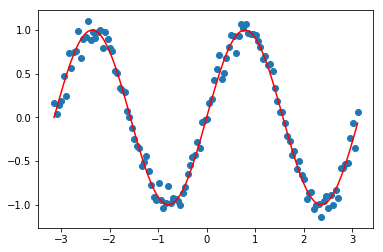

In [25]:
plt.scatter(x, y_real)
plt.plot(x, y_exp, 'r-')
plt.show()